# Import files

In [1]:
from Strats.PairTradingStrat import *
from Strats.PortfolioMetrics import *
from Strats.WRC import *

import warnings

warnings.filterwarnings("ignore")

# Run Strats

In [2]:
# Get all available tickers
response = requests.get(f"{BASE_URL}/ticker/price")
data = response.json()
BTC_pairs = [i["symbol"] for i in data if "BTC" in i["symbol"]]


In [ ]:
coint_pairs = get_coint_pairs(BTC_pairs, interval = '1d', start_date="2023-01-01", end_date="2023-12-31")
len(coint_pairs)

In [3]:
# test_pairs = coint_pairs[10:12]
test_pairs = ['WBTCBTC', 'OGBTC']
print(test_pairs)

symbol_manager = BinanceSymbolManager()
# Add symbols
for t in test_pairs:
    print(symbol_manager.add_symbol(t))  # Success

price_fetcher = BinancePriceFetcher(symbol_manager.get_symbols())
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="1d",
        start_date="2023-01-01",
        end_date="2024-12-31"
    )

pair_portfolio

['WBTCBTC', 'OGBTC']
'WBTCBTC' added successfully.
'OGBTC' added successfully.


,timestamp,OGBTC,WBTCBTC
0,2023-01-01,0.000142,0.9982
1,2023-01-02,0.000144,0.9988
2,2023-01-03,0.000144,0.9984
3,2023-01-04,0.000143,0.9994
4,2023-01-05,0.000148,0.9987
...,...,...,...
726,2024-12-27,0.000050,0.9990
727,2024-12-28,0.000051,0.9989
728,2024-12-29,0.000051,0.9993
729,2024-12-30,0.000052,0.9991


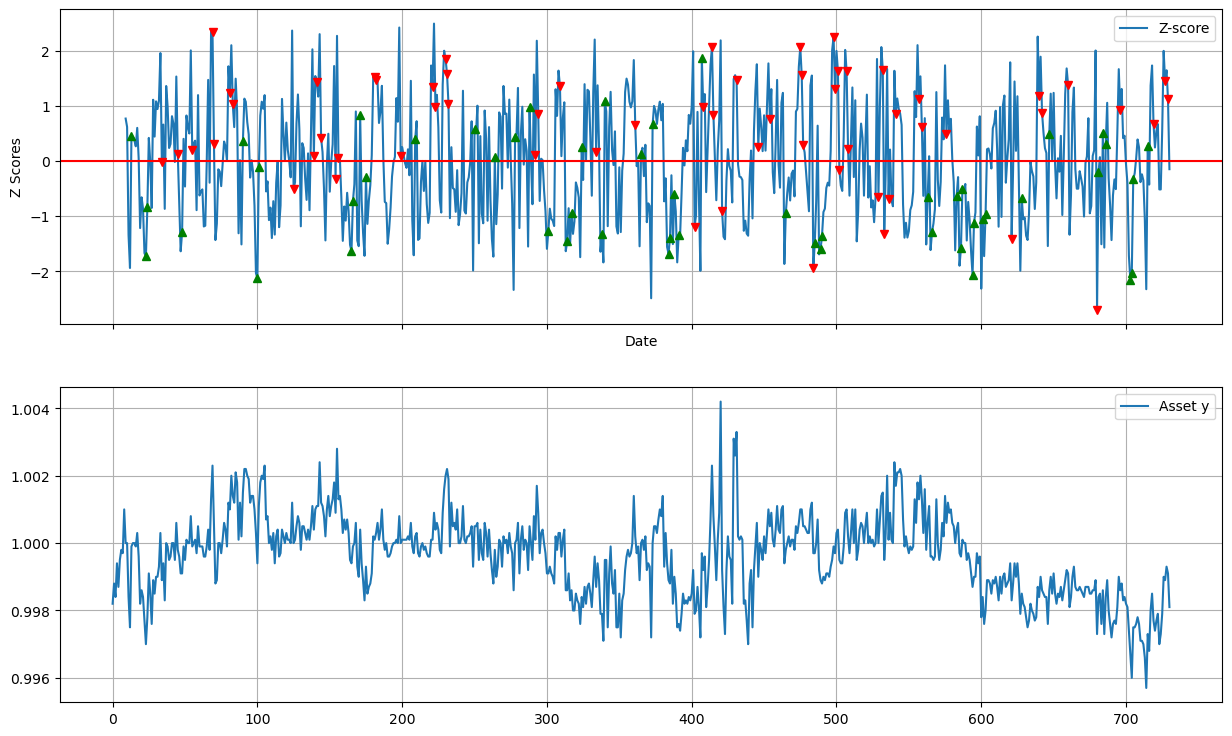

In [4]:
weights = np.array([1/len(test_pairs) for i in range(len(test_pairs))])
model = pair_trading(pair_portfolio.copy(), weights)
spread = model.generate_signals(lookback=10, threshold=1.5)
model.plot_signals(test_pairs[0])

In [5]:
pnl_df = model.computePortfolioPnL(test_start_date="2024-01-01")
pnl_df

,timestamp,total_daily_pnl,total_pnl
0,2023-01-01,0.000000,0.000000
1,2023-01-02,-0.000050,-0.000050
2,2023-01-03,0.000100,0.000100
3,2023-01-04,-0.000100,-0.000100
4,2023-01-05,0.000397,0.000397
...,...,...,...
361,2023-12-28,0.000018,0.019000
362,2023-12-29,0.000197,0.019178
363,2023-12-30,-0.000794,0.018187
364,2023-12-31,-0.000321,0.018660


In [6]:
price_fetcher = BinancePriceFetcher(test_pairs)
# Fetch pair historical price
pair_portfolio = price_fetcher.get_grp_historical_ohlcv(
        interval="1d",
        start_date="2024-01-01",
        end_date="2024-12-31"
    )

weights = np.array([0.5, 0.5])  # Equal-weighted

# Initialize strategy
strategy = SimpleStrategy(
    tickers=test_pairs,
    weights=weights,
    data=pair_portfolio
)
print(pair_portfolio.shape)
# Get momentum strategy returns
momentum_returns = strategy.momentum_strategy(lookback=30, hold_period=10)

(366, 3)


# Comparison

In [7]:
returns = pd.DataFrame()
returns["Momentum"] = momentum_returns
returns["Pair_Trade"] = pnl_df[("total_daily_pnl")]

port_metrics = PortfolioMetrics(returns.dropna())
summary = port_metrics.summary(risk_free_rate=0)
print(summary)

            Annualized Return  Annualized Volatility  Sharpe Ratio  \
Momentum            -0.181825               1.477234      0.282065   
Pair_Trade           0.655742               0.059410      8.525673   

            Max Drawdown Duration  Max Drawdown  Calmar Ratio   Skewness  \
Momentum                      191     -0.569332     -0.319366  14.826098   
Pair_Trade                    191     -0.105328      6.225713  -0.836558   

              Kurtosis  VaR (5%)  CVaR (5%)  Tail Ratio  Omega Ratio  
Momentum    243.819066 -0.016328  -0.054185    0.466174     1.262897  
Pair_Trade    1.743490 -0.016328        NaN    0.466174     4.160143  


In [20]:
wrc = WhiteRealityCheck(strategies=returns["Pair_Trade"], benchmark=returns["Momentum"])
wrc.run()
wrc.superior_strategies()

White Reality Check Results:
p-value: lower         0.504
consistent    0.504
upper         0.504
dtype: float64
Superior strategy indices:
[]


[]